# **Data Exploration and Collecting**

In [ ]:
%%capture
!pip install mediapipe

In [ ]:
#liberaries of data
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
import scipy.io
#liberaries of model and video
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import cv2
import mediapipe as mp
import numpy as np

In [ ]:
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

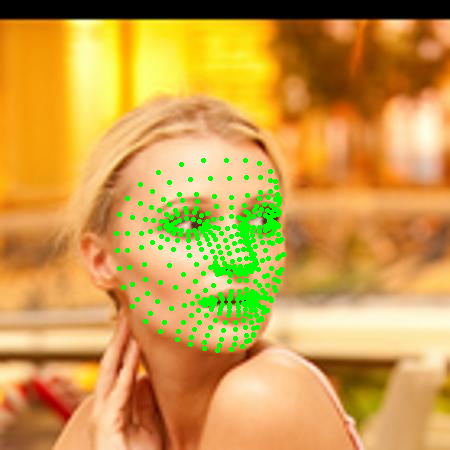

In [ ]:
# choosing random image
random_file = 'image00838'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

In [ ]:
dict = {}
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    for i in range(1, 4376):
        try:
            random_file = 'image'+str(i).zfill(5)
            image = cv2.imread('./AFLW2000/'+random_file+'.jpg')
            mat_file = sio.loadmat('./AFLW2000/'+random_file+'.mat')
            pose_para = mat_file["Pose_Para"][0][:3]
            pitch = pose_para[0]
            yaw = pose_para[1]
            roll = pose_para[2]

            dict[random_file] = {'pitch':pitch,'yaw':yaw,'roll':roll}

            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
            # looping over the faces in the image
                for face in results.multi_face_landmarks:
                    # for landmark in face.landmark:
                    for index, landmark in enumerate(face.landmark):
                        dict[random_file]["x_"+str(index)] = landmark.x
                        dict[random_file]["y_"+str(index)] = landmark.y
        except:
            pass


In [ ]:
df = pd.DataFrame.from_dict(dict,orient='index')
df.to_csv('AFLW2001.csv')

# **Data Preprocessing**

In [ ]:
df1 = pd.read_csv("/content/AFLW2001.csv")

In [ ]:
df1.head()

,Unnamed: 0,pitch,yaw,roll,x_0,y_0,x_1,y_1,x_2,y_2,...,x_463,y_463,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467
0,image00002,-0.399231,0.018227,0.085676,0.485651,0.686890,0.489194,0.639721,0.489802,0.647256,...,0.559712,0.485137,0.548437,0.492813,0.541429,0.500371,0.665668,0.471336,0.676091,0.464005
1,image00004,0.470065,1.189533,0.300959,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,...,0.522467,0.506956,0.511393,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387
2,image00006,-0.184650,0.881137,-0.236852,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,...,0.334413,0.717794,0.330334,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798
3,image00008,-0.175379,0.299208,-0.373374,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,...,0.507567,0.500958,0.497731,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623
4,image00010,-0.882169,1.198004,-1.033374,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1.shape

(2000, 940)

***Check Nulls***

In [ ]:
df1.isnull().sum()

Unnamed: 0      0
pitch           0
yaw             0
roll            0
x_0           147
             ... 
y_465         147
x_466         147
y_466         147
x_467         147
y_467         147
Length: 940, dtype: int64

***Drop Nulls***

In [ ]:
df1.dropna(inplace= True)

In [ ]:
df1.isnull().sum()

Unnamed: 0    0
pitch         0
yaw           0
roll          0
x_0           0
             ..
y_465         0
x_466         0
y_466         0
x_467         0
y_467         0
Length: 940, dtype: int64

**Drop unneccesary columns**

In [ ]:
#drop unnamed:0
df1.drop(['Unnamed: 0'], axis=1 , inplace=True)

In [ ]:
df1.shape

(1853, 939)

**check duplicate**

In [ ]:
df1.duplicated().sum()

0

In [ ]:
df1.describe()

,pitch,yaw,roll,x_0,y_0,x_1,y_1,x_2,y_2,x_3,...,x_463,y_463,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467
count,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,...,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000
mean,-0.095366,0.013611,-0.033167,0.505036,0.666149,0.503698,0.611075,0.504510,0.627596,0.490213,...,0.544489,0.497822,0.535768,0.503258,0.530948,0.507431,0.621081,0.485716,0.629547,0.478221
std,0.549292,0.580266,0.649282,0.041261,0.028346,0.053271,0.029041,0.037840,0.024675,0.044587,...,0.033976,0.024391,0.033202,0.023010,0.033922,0.022426,0.047496,0.038984,0.050135,0.041212
min,-12.457202,-6.130066,-16.969362,0.256906,0.179093,0.227159,0.144636,0.249772,0.152404,0.222207,...,0.281731,0.049809,0.273721,0.055864,0.266672,0.060640,0.304541,0.032022,0.294275,0.024076
25%,-0.246453,-0.256714,-0.160274,0.482141,0.652247,0.469521,0.598221,0.481937,0.617026,0.460069,...,0.529124,0.484851,0.520338,0.491350,0.514206,0.496217,0.593103,0.463229,0.601160,0.454632
50%,-0.123371,0.019403,-0.017463,0.505162,0.668768,0.501536,0.614621,0.503587,0.629840,0.485371,...,0.545440,0.496684,0.537094,0.502106,0.532342,0.506317,0.626023,0.485355,0.635011,0.477745
75%,0.028133,0.305791,0.126460,0.526248,0.682794,0.537543,0.627792,0.525717,0.641242,0.516599,...,0.559289,0.509189,0.550134,0.513950,0.546662,0.517966,0.650143,0.506548,0.660787,0.499799
max,15.598820,3.277500,2.166107,0.928491,0.799190,0.929157,0.776498,0.923774,0.782066,0.901552,...,0.911897,0.719222,0.908871,0.720868,0.908686,0.723342,0.990572,0.741343,0.998658,0.750775


***this link countains picture with index of each point in face***

[https://github.com/HotaruK/mediapipe_demo/blob/main/keypoints/face_mesh_no.jpg](https://)


# **Feature Selection**


Most of the points in the face mesh are close to each other and don't offer new information.
I will choose Some usefull point as features and use it to to estimate the value of the rotation angles: pitch, yaw, and roll.

NOSE ---> x1 , y1

FOREHEAD ---> x10 , y10

LEFT_EYE ---> x33 , x33

RIGHT_EYE ---> x263 , y263

MOUTH_LEFT ---> x61 , y61

MOUTH_RIGHT ---> x291 , y291

CHIN ---> x199 , y199

some points not close to eash other

x_446 , y_446

x_398,y_398

x_173 , y_173

x_225 , y_225

x_93 , y_93

x_323 , y_323

In [ ]:
cleaned_df = df1[["x_1","y_1","x_10","y_10","x_33","y_33","x_263","y_263","x_61","y_61","x_291","y_291","x_199","y_199","x_446","y_446","x_398","y_398","x_173","y_173","x_225","y_225","x_93","y_93","x_323","y_323","pitch","yaw","roll"]]

In [ ]:
cleaned_df.to_csv("cleanad_data.csv")

In [ ]:
cleaned_df

,x_1,y_1,x_10,y_10,x_33,y_33,x_263,y_263,x_61,y_61,...,y_173,x_225,y_225,x_93,y_93,x_323,y_323,pitch,yaw,roll
0,0.489194,0.639721,0.521101,0.295806,0.354743,0.441597,0.669543,0.473942,0.403752,0.680927,...,0.462293,0.345675,0.417577,0.288699,0.496140,0.740419,0.543670,-0.399231,0.018227,0.085676
1,0.417273,0.592251,0.488381,0.390755,0.466445,0.498001,0.590615,0.503390,0.448146,0.663406,...,0.499004,0.458018,0.483707,0.534591,0.574622,0.746846,0.598478,0.470065,1.189533,0.300959
2,0.321328,0.776498,0.312070,0.647554,0.242887,0.716360,0.375262,0.713755,0.273441,0.808191,...,0.716078,0.239387,0.705879,0.199822,0.755718,0.397238,0.752168,-0.184650,0.881137,-0.236852
3,0.469521,0.653913,0.407994,0.381680,0.355064,0.536397,0.601773,0.456452,0.469025,0.706727,...,0.520608,0.336804,0.518862,0.387560,0.593233,0.738202,0.484547,-0.175379,0.299208,-0.373374
5,0.492729,0.604797,0.444616,0.330580,0.351501,0.510302,0.608139,0.455517,0.456137,0.708352,...,0.493440,0.340464,0.493645,0.310283,0.637813,0.716974,0.547933,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.532837,0.625785,0.518629,0.329252,0.350857,0.486368,0.631279,0.482786,0.425503,0.693179,...,0.489309,0.346490,0.461982,0.233205,0.564114,0.637071,0.555501,-0.306358,-0.283822,0.038554
1992,0.565286,0.635285,0.563298,0.321137,0.388783,0.468889,0.661578,0.481915,0.443182,0.699508,...,0.480641,0.386777,0.438803,0.266607,0.539907,0.662372,0.553464,-0.367547,-0.429723,0.122791
1994,0.604407,0.627700,0.664646,0.387628,0.503506,0.485360,0.736257,0.551269,0.507515,0.689498,...,0.505863,0.505122,0.454650,0.414276,0.552086,0.751213,0.646894,-0.156035,0.567114,-0.108536
1995,0.500626,0.637631,0.533881,0.288130,0.346130,0.452526,0.678375,0.485406,0.412065,0.699271,...,0.468077,0.340028,0.423331,0.263226,0.518522,0.726947,0.566283,-0.197102,-0.070430,0.105118


In [ ]:
cleaned_df

,x_1,y_1,x_10,y_10,x_33,y_33,x_263,y_263,x_61,y_61,...,y_173,x_225,y_225,x_93,y_93,x_323,y_323,pitch,yaw,roll
0,0.489194,0.639721,0.521101,0.295806,0.354743,0.441597,0.669543,0.473942,0.403752,0.680927,...,0.462293,0.345675,0.417577,0.288699,0.496140,0.740419,0.543670,-0.399231,0.018227,0.085676
1,0.417273,0.592251,0.488381,0.390755,0.466445,0.498001,0.590615,0.503390,0.448146,0.663406,...,0.499004,0.458018,0.483707,0.534591,0.574622,0.746846,0.598478,0.470065,1.189533,0.300959
2,0.321328,0.776498,0.312070,0.647554,0.242887,0.716360,0.375262,0.713755,0.273441,0.808191,...,0.716078,0.239387,0.705879,0.199822,0.755718,0.397238,0.752168,-0.184650,0.881137,-0.236852
3,0.469521,0.653913,0.407994,0.381680,0.355064,0.536397,0.601773,0.456452,0.469025,0.706727,...,0.520608,0.336804,0.518862,0.387560,0.593233,0.738202,0.484547,-0.175379,0.299208,-0.373374
5,0.492729,0.604797,0.444616,0.330580,0.351501,0.510302,0.608139,0.455517,0.456137,0.708352,...,0.493440,0.340464,0.493645,0.310283,0.637813,0.716974,0.547933,-0.026812,0.011965,-0.220662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,0.532837,0.625785,0.518629,0.329252,0.350857,0.486368,0.631279,0.482786,0.425503,0.693179,...,0.489309,0.346490,0.461982,0.233205,0.564114,0.637071,0.555501,-0.306358,-0.283822,0.038554
1992,0.565286,0.635285,0.563298,0.321137,0.388783,0.468889,0.661578,0.481915,0.443182,0.699508,...,0.480641,0.386777,0.438803,0.266607,0.539907,0.662372,0.553464,-0.367547,-0.429723,0.122791
1994,0.604407,0.627700,0.664646,0.387628,0.503506,0.485360,0.736257,0.551269,0.507515,0.689498,...,0.505863,0.505122,0.454650,0.414276,0.552086,0.751213,0.646894,-0.156035,0.567114,-0.108536
1995,0.500626,0.637631,0.533881,0.288130,0.346130,0.452526,0.678375,0.485406,0.412065,0.699271,...,0.468077,0.340028,0.423331,0.263226,0.518522,0.726947,0.566283,-0.197102,-0.070430,0.105118


In [ ]:
cleaned_df.shape

(1853, 29)

In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1853 entries, 0 to 1999
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_1     1853 non-null   float64
 1   y_1     1853 non-null   float64
 2   x_10    1853 non-null   float64
 3   y_10    1853 non-null   float64
 4   x_33    1853 non-null   float64
 5   y_33    1853 non-null   float64
 6   x_263   1853 non-null   float64
 7   y_263   1853 non-null   float64
 8   x_61    1853 non-null   float64
 9   y_61    1853 non-null   float64
 10  x_291   1853 non-null   float64
 11  y_291   1853 non-null   float64
 12  x_199   1853 non-null   float64
 13  y_199   1853 non-null   float64
 14  x_446   1853 non-null   float64
 15  y_446   1853 non-null   float64
 16  x_398   1853 non-null   float64
 17  y_398   1853 non-null   float64
 18  x_173   1853 non-null   float64
 19  y_173   1853 non-null   float64
 20  x_225   1853 non-null   float64
 21  y_225   1853 non-null   float64
 22  

# **Spliting Dataset and Train the Model**

In [ ]:
#split data into train,validate,test set
x = cleaned_df.drop(columns=["pitch","yaw","roll"])
y = cleaned_df[["pitch","yaw","roll"]]
x_train , x_validate ,y_train  , y_validate = train_test_split(x,y,test_size=0.20, random_state=42)
x_validate,x_test , y_validate  ,y_test = train_test_split(x_validate,y_validate,test_size=0.50, random_state=42)

In [ ]:
#train model with pitch label
model1 = SVR(kernel='rbf', gamma= 1, epsilon = 0.1, C= 10)
model1.fit(x_train,y_train["pitch"])
#model1.score(x_validate,y_validate["pitch"])

SVR(C=10, gamma=1)

In [ ]:
#train model with yaw label
model2 = SVR(kernel='rbf', gamma= 0.8, C= 0.6)
model2.fit(x_train,y_train["yaw"])
#model2.score(x_validate,y_validate["yaw"])

SVR(C=0.6, gamma=0.8)

In [ ]:
#train model with roll label
model3 = SVR(kernel= 'linear', gamma= 0.001, epsilon= 0.01, C=1000)
model3.fit(x_train,y_train["roll"])
#model3.score(x_validate,y_validate["roll"])

SVR(C=1000, epsilon=0.01, gamma=0.001, kernel='linear')

# Testing model on some random pictures

In [ ]:
#index of points which need to take from photo
list1 = [2,3,20,21,66,67,526,527,122,123,582,583,398,399,892,893,796,797,346,347,450,451,186,187,646,647]


In [ ]:
new_df = []
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
  try:
            image = cv2.imread("/content/AFLW2000/image00021.jpg")

            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
            # looping over the faces in the image
                for face in results.multi_face_landmarks:
                    # for landmark in face.landmark:
                    for index, landmark in enumerate(face.landmark):
                        new_df.append(landmark.x)
                        new_df.append(landmark.y)
  except:
    pass

In [ ]:
new_df = np.array(new_df)
new_df =new_df[list1]

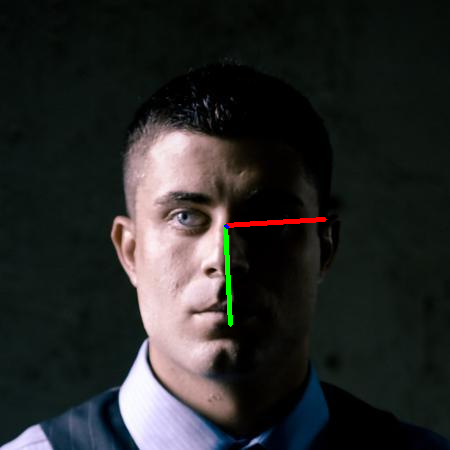

In [ ]:
random = "image00021"
image = cv2.imread('/content/AFLW2000/'+random+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

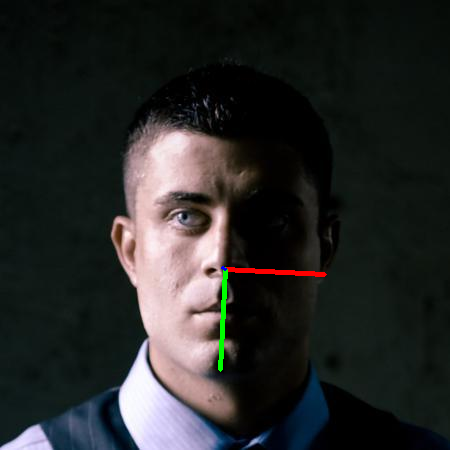

In [ ]:
image = cv2.imread('/content/AFLW2000/image00021.jpg')
pitch = model1.predict(new_df.reshape(1,-1))
yaw = model2.predict(new_df.reshape(1,-1))
roll = model3.predict(new_df.reshape(1,-1))
cv2_imshow(draw_axis(image,pitch,yaw,roll,new_df[0]*image.shape[1],new_df[1]*image.shape[0]))

In [ ]:
new_df = []
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
  try:
            image = cv2.imread("//content/promo-f479f33fd9304b3997cc0f7c97c1a245-1aebc5f0ea88447e840db1f8fd67f802.jpg")

            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
            # looping over the faces in the image
                for face in results.multi_face_landmarks:
                    # for landmark in face.landmark:
                    for index, landmark in enumerate(face.landmark):

                        new_df.append(landmark.x)
                        new_df.append(landmark.y)
  except:
    pass

In [ ]:
new_df = np.array(new_df)
new_df = new_df[list1]

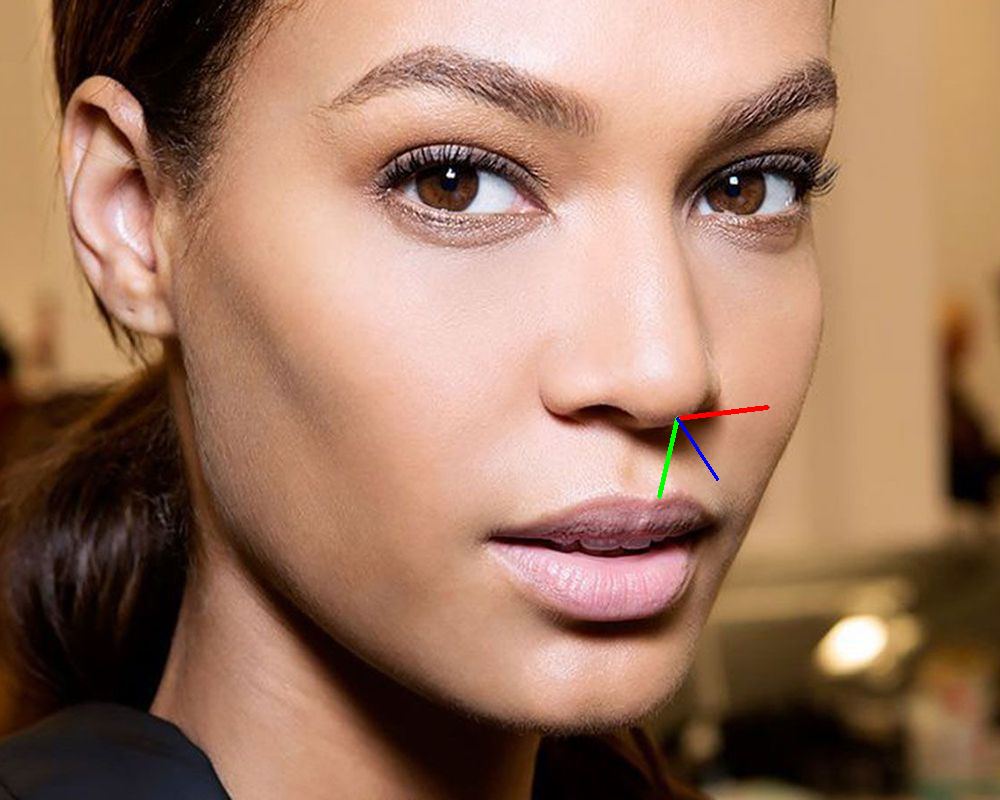

In [ ]:
image = cv2.imread('/content/promo-f479f33fd9304b3997cc0f7c97c1a245-1aebc5f0ea88447e840db1f8fd67f802.jpg')


pitch = model1.predict(new_df.reshape(1,-1))
yaw = model2.predict(new_df.reshape(1,-1))
roll = model3.predict(new_df.reshape(1,-1))
cv2_imshow(draw_axis(image,pitch,yaw,roll,new_df[0]*image.shape[1],new_df[1]*image.shape[0]))

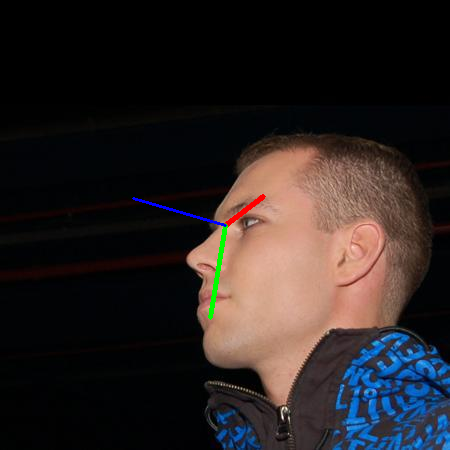

In [ ]:
random = "image00475"
image = cv2.imread('/content/AFLW2000/'+random+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [ ]:
new_df = []
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
  try:
            image = cv2.imread("//content/AFLW2000/image00475.jpg")

            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
            # looping over the faces in the image
                for face in results.multi_face_landmarks:
                    # for landmark in face.landmark:
                    for index, landmark in enumerate(face.landmark):
                        new_df.append(landmark.x)
                        new_df.append(landmark.y)
  except:
    pass

In [ ]:
new_df = np.array(new_df)
new_df =new_df[list1]

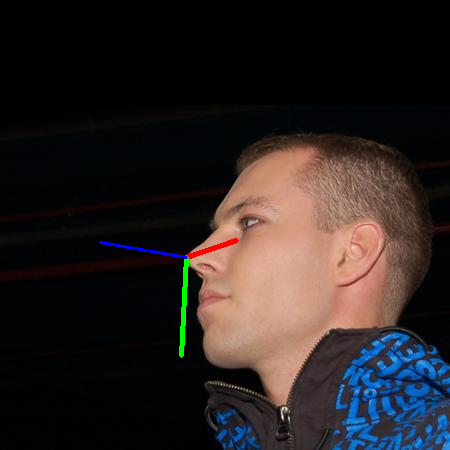

In [ ]:
image = cv2.imread('/content/AFLW2000/image00475.jpg')


pitch = model1.predict(new_df.reshape(1,-1))
yaw = model2.predict(new_df.reshape(1,-1))
roll = model3.predict(new_df.reshape(1,-1))
cv2_imshow(draw_axis(image,pitch,yaw,roll,new_df[0]*image.shape[1],new_df[1]*image.shape[0]))

# **Random Search on each model**

In [ ]:
#random search pitch
# Define the hyperparameter space
param_grid = {
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'C': [1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

# Initialize the SVR model
model = SVR()

# Perform random search
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, random_state=42)
random_search.fit(x_train, y_train["pitch"])

# Print the best hyperparameters
print(random_search.best_params_)
print(mean_squared_error(y_validate["pitch"], random_search.predict(x_validate)))

{'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.1, 'C': 10}
0.025001268472246027


In [ ]:
#random search yaw
# Define the hyperparameter space
param_grid = {
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'C': [1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

# Initialize the SVR model
model = SVR()

# Perform random search
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, random_state=42)
random_search.fit(x_train, y_train["yaw"])

# Print the best hyperparameters
print(random_search.best_params_)
print(mean_squared_error(y_validate["yaw"], random_search.predict(x_validate)))

{'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.001, 'C': 100}
0.04294177020259152


In [ ]:
#random search roll
# Define the hyperparameter space
param_grid = {
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'C': [1, 10, 100, 1000],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

# Initialize the SVR model
model = SVR()

# Perform random search
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, random_state=42)
random_search.fit(x_train, y_train["roll"])

# Print the best hyperparameters
print(random_search.best_params_)
print(mean_squared_error(y_validate["roll"], random_search.predict(x_validate)))

{'kernel': 'linear', 'gamma': 0.001, 'epsilon': 0.01, 'C': 1000}
0.02915924424531933


# **Teasting Model on Video**

In [ ]:
# Load the video
video_path = "/content/#shorts الكبير__صور لعبة السبيط من مسلسل الكبير بجودة عالية😉.mp4"
cap = cv2.VideoCapture(video_path)

# Initialize the MediaPipe Face Mesh model
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, min_detection_confidence=0.5)

# Define a list of landmark indices to extract
list1 = [2,3,20,21,66,67,526,527,122,123,582,583,398,399,892,893,796,797,346,347,450,451,186,187,646,647]

# Initialize an empty list to store the landmarks
landmarks = []

# Define the output video path
output_path = "/content/elkebeer_head_pose_estimation.mp4"

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Process each frame in the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with the Face Mesh model
    results = face_mesh.process(frame_rgb)

    # Extract the landmarks
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            new_df = []
            for index, landmark in enumerate(face_landmarks.landmark):
                new_df.append(landmark.x)
                new_df.append(landmark.y)

            # Convert the landmarks to a NumPy array
            new_df = np.array(new_df)

            # Extract the desired landmarks
            new_df = new_df[list1]

            # Predict the angles
            pitch = model1.predict(new_df.reshape(1,-1))
            yaw = model2.predict(new_df.reshape(1,-1))
            roll = model3.predict(new_df.reshape(1,-1))

            # Draw the axis on the frame
            frame = draw_axis(frame, pitch, yaw, roll, new_df[0]*frame.shape[1], new_df[1]*frame.shape[0])

    # Write the frame with the drawn head pose to the output video
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects
cap.release()
out.release()
cv2.destroyAllWindows()

print("Output video saved at:", output_path)


Output video saved at: /content/elkebeer_head_pose_estimation.mp4


# **OUTPUT VIDEO**


[https://drive.google.com/file/d/1lcqTuJiiYrOs4R2ZjgQm-Ll7lQFKpd8X/view?usp=sharing]